# Egg-box Likelihood with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = 5 (2. + \prod_i cos(\frac{\theta_i}{2})))$

and

$P(x) = \mathcal{U}[x \mid 0, 10 \pi]$.

## Overview

We'll cover the following topics:

1. How to handle multimodal behaviour with JAXNS.
2. How to use the `prior_chain` outside the nested sampler, e.g. to sample/plot.
3. How to brute-force compute the evidence for comparison.

In [1]:

from jaxns import NestedSampler
from jaxns import PriorChain, UniformPrior
from jaxns import summary, analytic_log_evidence
from jaxns.internals.maps import prepare_func_args
from jaxns import plot_cornerplot, plot_diagnostics
from jax import random, jit, vmap
from jax import numpy as jnp
import pylab as plt

In [2]:
def log_likelihood(theta):
    return 5. * (2. + jnp.prod(jnp.cos(0.5 * theta)))


ndim = 2
with PriorChain() as prior_chain:
    UniformPrior('theta', low=jnp.zeros(ndim), high=jnp.pi * 10. * jnp.ones(ndim))

log_Z_true = analytic_log_evidence(prior_chain=prior_chain, log_likelihood=log_likelihood, S=250)
print(f"True log(Z)={log_Z_true}")

INFO[2022-05-30 10:53:01,704]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-30 10:53:01,705]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-05-30 10:53:01,706]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-05-30 10:53:01,706]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


True log(Z)=12.401798248291016


WARNING[2022-05-30 10:53:02,227]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


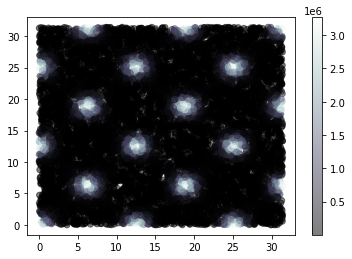

In [3]:
# To use the prior_chain to sample from, e.g. for plotting, we should first build it. This typically gets done inside the nested sampler, and if not should be done manually.
prior_chain.build()

theta = vmap(lambda key: prior_chain(prior_chain.sample_U_flat(key)))(
    random.split(random.PRNGKey(0), 10000))
# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(lambda theta: prepare_func_args(log_likelihood)(**theta))(theta)
sc = plt.scatter(theta['theta'][:, 0], theta['theta'][:, 1], c=jnp.exp(lik), cmap='bone', alpha=0.5)
plt.colorbar(sc)
plt.show()

In [4]:
# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(log_likelihood, prior_chain)
# We jit-compile
ns = jit(ns)
# We run, with any parameters desired. In this case, without any tuning.
results = ns(random.PRNGKey(4525325))


WARNING[2022-05-30 10:53:03,309]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step
WARNING[2022-05-30 10:53:03,310]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1882: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


In [5]:
# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 22463
# samples: 1200
# likelihood evals / sample: 18.7
--------
logZ=12.365 +- 0.088
H=1500000.0
ESS=430
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 15.7 +- 9.5 | 2.1 / 16.9 / 30.4 | 13.2 | 18.9
theta[1]: 14.8 +- 8.9 | 4.3 / 13.8 / 25.8 | 1.3 | 6.3
--------


'--------\nTermination Conditions:\nSmall remaining evidence\n--------\n# likelihood evals: 22463\n# samples: 1200\n# likelihood evals / sample: 18.7\n--------\nlogZ=12.365 +- 0.088\nH=1500000.0\nESS=430\n--------\ntheta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntheta[0]: 15.7 +- 9.5 | 2.1 / 16.9 / 30.4 | 13.2 | 18.9\ntheta[1]: 14.8 +- 8.9 | 4.3 / 13.8 / 25.8 | 1.3 | 6.3\n--------'

WARNING[2022-05-30 10:53:12,700]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING[2022-05-30 10:53:13,333]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


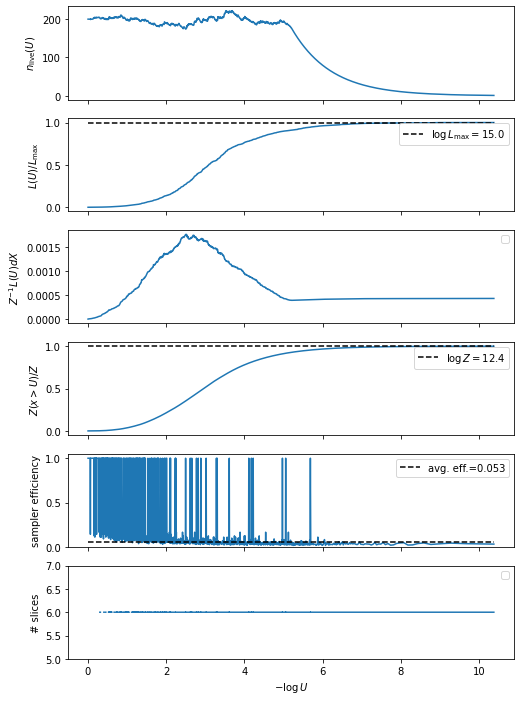

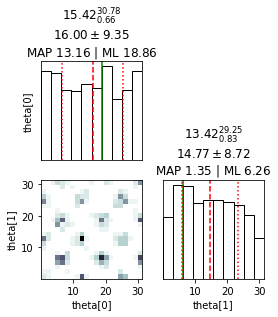

In [6]:
# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)